## Nonlinear MPC with Kinematic Bicycle Model

The bicycle model is the same one used in <a href=https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4>this paper (Figure 3)</a>

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import bezier

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

from road                import iso_double_lane_change as test_road
#from complex_track_2                import complex_track_2 as test_road

# Generates a totally straight test_road
#test_road = np.empty((100,2))
#for i in range(100):
#    test_road[i,0] = i
#    test_road[i,1] = -0.001*i if i > 60 else 0.001*i

# Flips the test road, so the car goes from the end to the start.
#test_road = np.flip(test_road, 0)


## Initialize the car and road model

In [2]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.075)
DESIRED_SPEED = 10.0

In [3]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road,                    # Road centerline points
                        road_width  = np.ones(n_test_road_pts)*5.0, # constant lane width of 5 meters
                        P           = 10) # Number of points to try curve-fitting at a time

## Boundary functions
We represent the road boundaries as a series of polygons. At each step $x_k$, $x_{k+1},...,x_N$, the car's x-y position is bounded by a 4-sided polygon.
The polygons for successive states overlap, allowing the car to steer and slow down / speed up within the confines of the road.

This image shows 5 successive bounds from $k$ to $k+5$. The $k+5^{th}$ bound is in red.
![title](polygon_bounds.png)

In [4]:
'''
def road_center(model:KinematicBicycleCar, k:int)->np.array:

    (xy, angle, _) = roadrunner.evaluate(model.step*np.sum(model.state_estimate[2,:k]), full_data=True)

    center = np.empty((3,))
    center[0:2] = np.reshape(xy, 2)
    center[2]   = angle
    return center

# Test

def bound_x(model:KinematicBicycleCar, k:int)->[np.array]:
    # Returns a 4-sided polygon bound, like this:
    # x2-------x3
    #   \  o  /
    #  x1-----x4
    # successive bounds will overlap each other
    # so there is freedom to slow down or speed up the vehicle.
    
    eps = np.finfo(np.float64).eps # Machine Precision
    
    dist_behind = (k-5)*model.step*DESIRED_SPEED # 5 steps behind * timestep * velocity at point k
    #print("Looking behind by", dist_behind)
    (center_minus, angle_minus, width_minus) = roadrunner.evaluate(dist_behind, full_data=True)
    
    dist_ahead = (k+5)*model.step*DESIRED_SPEED # 5 steps ahead * timestep * velocity at point k
    #print("Looking ahead by", dist_ahead)
    (center_plus, angle_plus, width_plus) = roadrunner.evaluate(dist_ahead, full_data=True)

    center_minus = np.reshape(center_minus,(2,))
    center_plus = np.reshape(center_plus,(2,))
    
    # we either have 0.0 >= ax + by + c >= -Inf
    # or             Inf >= ax + by + c >= 0.0
    
    # since y = (x-x0)*slope + y0
    # use the line 0 = x*slope - y + y0 - x0*slope as the upper / lower bound
    
    #            (upper)
    #     p2-----slope23------p3
    #    /                    /
    # slope12 (upper)   slope34 (lower)
    #  /                   /
    # p1-----slope14-----p4
    #        (lower)
    
    p1 = np.reshape(np.array([center_minus[0] + width_minus/2.0*np.cos(angle_minus-np.pi/2),
                   center_minus[1] + width_minus/2.0*np.sin(angle_minus-np.pi/2)]), (2,))
    
    p2 = np.reshape(np.array([center_minus[0] + width_minus/2.0*np.cos(angle_minus+np.pi/2),
                   center_minus[1] + width_minus/2.0*np.sin(angle_minus+np.pi/2)]), (2,))
    
    p3 = np.reshape(np.array([center_plus[0] + width_plus/2.0*np.cos(angle_plus+np.pi/2),
                   center_plus[1] + width_plus/2.0*np.sin(angle_plus+np.pi/2)]), (2,))
    
    p4 = np.reshape(np.array([center_plus[0] + width_plus/2.0*np.cos(angle_plus-np.pi/2),
                   center_plus[1] + width_plus/2.0*np.sin(angle_plus-np.pi/2)]), (2,))
    
    # This point is approximately the center of the bound
    # It should definitely be a feasible point
    center_x, center_y = 0.5*(center_minus + center_plus)
    
    
    # The slopes between the points
    slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isnan(slope12) else slope12
    slope23 = (p3[1]-p2[1])/(p3[0]-p2[0]); slope23 = 1e4 if np.isnan(slope23) else slope23
    slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isnan(slope43) else slope43
    slope14 = (p1[1]-p4[1])/(p1[0]-p4[0]); slope14 = 1e4 if np.isnan(slope14) else slope14
    
    slopes = [(slope12, p1, p2), (slope23, p2, p3), (slope43, p4, p3), (slope14, p4, p1)]
    
    bounds = []
    for (slope, p, q) in slopes:
        offset = p[1]-p[0]*slope
        
        # We determine whether it is an upper or lower bound
        # by making sure center x,y is a feasible point
        
        if 0.0 <= center_x*slope + center_y*(-1.0) + offset and \
                  center_x*slope + center_y*(-1.0) + offset <= np.inf:
            bounds.append(np.array([np.inf, slope, -1.0, offset, 0.0]))
            
        elif -np.inf <= center_x*slope + center_y*(-1.0) + offset and \
                        center_x*slope + center_y*(-1.0) + offset <= 0.0:
            bounds.append(np.array([0.0, slope, -1.0, offset, -np.inf]))
        else:
            raise ValueError("HUGE ERROR at ", k, "a, b, c =", slope, -1.0, offset, "\ncenter", center_x, center_y)
    

    return bounds, np.vstack([p1,p2,p3,p4])
'''

'\ndef road_center(model:KinematicBicycleCar, k:int)->np.array:\n\n    (xy, angle, _) = roadrunner.evaluate(model.step*np.sum(model.state_estimate[2,:k]), full_data=True)\n\n    center = np.empty((3,))\n    center[0:2] = np.reshape(xy, 2)\n    center[2]   = angle\n    return center\n\n# Test\n\ndef bound_x(model:KinematicBicycleCar, k:int)->[np.array]:\n    # Returns a 4-sided polygon bound, like this:\n    # x2-------x3\n    #   \\  o  /\n    #  x1-----x4\n    # successive bounds will overlap each other\n    # so there is freedom to slow down or speed up the vehicle.\n    \n    eps = np.finfo(np.float64).eps # Machine Precision\n    \n    dist_behind = (k-5)*model.step*DESIRED_SPEED # 5 steps behind * timestep * velocity at point k\n    #print("Looking behind by", dist_behind)\n    (center_minus, angle_minus, width_minus) = roadrunner.evaluate(dist_behind, full_data=True)\n    \n    dist_ahead = (k+5)*model.step*DESIRED_SPEED # 5 steps ahead * timestep * velocity at point k\n    #prin

In [5]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt - done

## Run the MPC algorithm

In [6]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(car.step*10*DESIRED_SPEED)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]
car.set_initial(DESIRED_SPEED, roadrunner)
print("Starting at initial conditions", ic)

# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
mpcprob = MpcProblem(car, roadrunner,    # casadi.DaeBuilder()
                    )

Starting at initial conditions [12.740244943876178, 0.9730302063349124, 10.0, 0.00505619734257304]


<IPython.core.display.Javascript object>


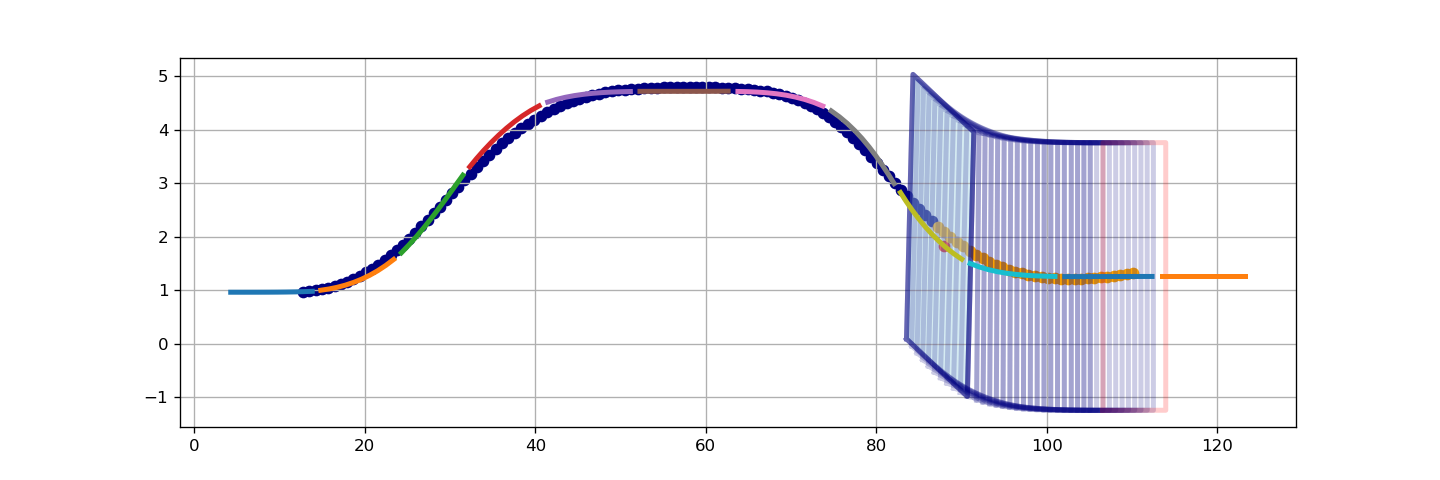


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      239
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      241

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      227
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      253

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      224
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      256

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      225
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      255

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      237
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      243

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      231
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      249

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      219
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      261

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      207
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      273

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      280

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      280

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      201
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      279

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      280

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      233
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      247

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      280

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      280

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      209
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      271

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      221
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      259

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      233
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      247

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      241
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      239

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      253
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      227

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      265
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      215

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      280
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      280
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:362: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isnan(slope43) else slope43
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:374: RuntimeWarning: invalid value encountered in double_scalars
  if 0.0 <= center_x*slope + center_y*(-1.0) + offset and \
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:378: RuntimeWarning: invalid value encountered in double_scalars
  elif -np.inf <= center_x*slope + center_y*(-1.0) + offset and \


In [7]:
%matplotlib notebook

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 500

def desired_speed(k:int):
    return DESIRED_SPEED

x_plan = np.empty((mpcprob.model.n,n_runs+1)) # store the steps that get executed (n_runs)
u_plan = np.empty((mpcprob.model.m,n_runs))   # store the control inputs that get executed
x_true = np.empty((mpcprob.model.n,n_runs+1)) # store the state as simulated for each control input by an integrator
x_true[:,0] = ic # initial conditions
x_plan[:,0] = ic
# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+mpcprob.model.N,4,2))

fig_traj = plt.figure(figsize=(12,4))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(x_true[0,0], x_true[1,0], color="red")[0]
#ax_traj.quiver(x_true[0,0], x_true[1,0], x_true[2,0]*np.cos(x_true[3,0]), x_true[2,0]*np.sin(x_true[3,0]), color="blue")
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0
try:
    while k < n_runs-1:
        # Solve the MPC problem
        xk_opt, uk_opt, sol = mpcprob.run(x_true[:,k])

        # Save the next state x_k+1 and control u_k+1
        for i in range(mpcprob.model.n):
            x_plan[i,k+1] = xk_opt[i][1]
        for i in range(mpcprob.model.m):
            u_plan[i,k] = uk_opt[i][1]
        x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])

        # Compute distance traveled (approximately)
        step_xy = np.linalg.norm(x_true[:,k+1]-x_true[:,k], 2)

        # Save the 4 points that represent the polygon boundary at state k
        bounds,p = roadrunner.bound_x(mpcprob.model.step,0, desired_speed)
        polygon_boundaries[k,:,:] = p
    
        #roadrunner.advance(step_xy)
        # Transform the point x_true to body frame coordinates to find the closest point near it on the curve.
        seg = roadrunner.segments[roadrunner._segment_ptr]
        pt = np.asfortranarray(
            roadrunner.to_body_frame(np.reshape(x_true[0:2,k+1],(1,2)), seg.transform_angle, seg.transform_offset))

        (s_new,_) = roadrunner.find_closest_pt(seg.curve,
                                            np.reshape(pt,(2,1)),
                                              start=roadrunner.current_pct,
                                              end=roadrunner.current_pct + 0.1)
        # Advance to s_new, the closest point on the curve.
        delta_s = s_new - roadrunner.current_pct
        step_xy = roadrunner.advance_s(delta_s)

        print("Advanced by", step_xy,"to", roadrunner.evaluate())


        # Plot arrows and x-y states
        ax_traj.clear()
        #ax_traj.quiver(x_true[0,:k], x_true[1,:k], x_true[2,:k]*np.cos(x_true[3,:k]), x_true[2,:k]*np.sin(x_true[3,:k]), color="blue")
        ax_traj.scatter(x_true[0,:k], x_true[1,:k], color="navy")
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        ax_traj.scatter(xy[0], xy[1], color="red")
        # Plot the polygon fill
        ax_traj.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)

        # Plot the plan
        for r in range(30-1):
            # Plot the polygon fill
            #ax_traj.fill(mpcprob.p_plot[r,:,0], mpcprob.p_plot[r,:,1], "lightblue", alpha=0.1)
            # Plot the line around each polygon
            ax_traj.plot(np.concatenate([mpcprob.p_plot[r,:,0],mpcprob.p_plot[r,0:1,0]]),
                    np.concatenate([mpcprob.p_plot[r,:,1],mpcprob.p_plot[r,0:1,1]]),
                    color="navy", alpha=0.2)
        ax_traj.plot(np.concatenate([mpcprob.p_plot[-1,:,0],mpcprob.p_plot[-1,0:1,0]]),
                    np.concatenate([mpcprob.p_plot[-1,:,1],mpcprob.p_plot[-1,0:1,1]]),
                    color="red", alpha=0.2)


        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange")


        fig_traj.canvas.draw()
        # Done!

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1

except (ValueError, OutOfRoadPointsException) as e:
    print(e)
    x_plan = x_plan[:,:k+1]
    u_plan = u_plan[:,:k]  
    x_true = x_true[:,k+1]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+mpcprob.model.N,:,:]
    
finally:
    roadrunner.plot(ax=ax_traj)
    fig_traj.canvas.draw()


In [8]:
# turn interactive off
plt.ioff()
# FOR PLOTTING: We also want to include the polygons for the lookahead steps k=1,...,N.
polygon_boundaries[k-1:k+mpcprob.model.N+2,:,:] = mpcprob.p_plot

## Control signals: acceleration and steering angle

<IPython.core.display.Javascript object>


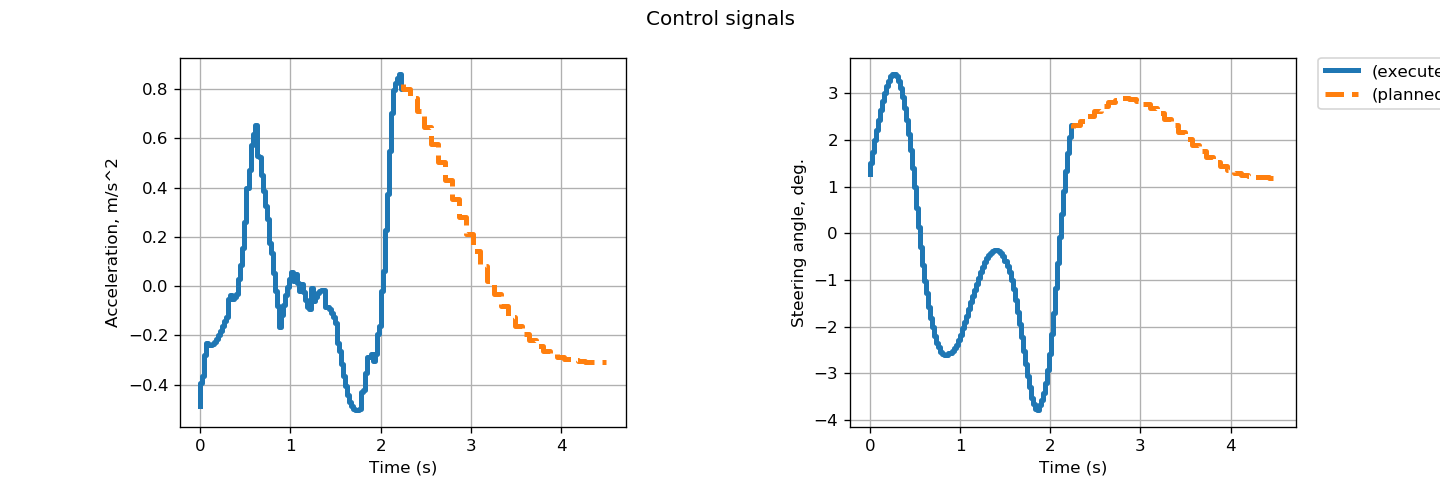

In [9]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
plt.show()

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

<IPython.core.display.Javascript object>


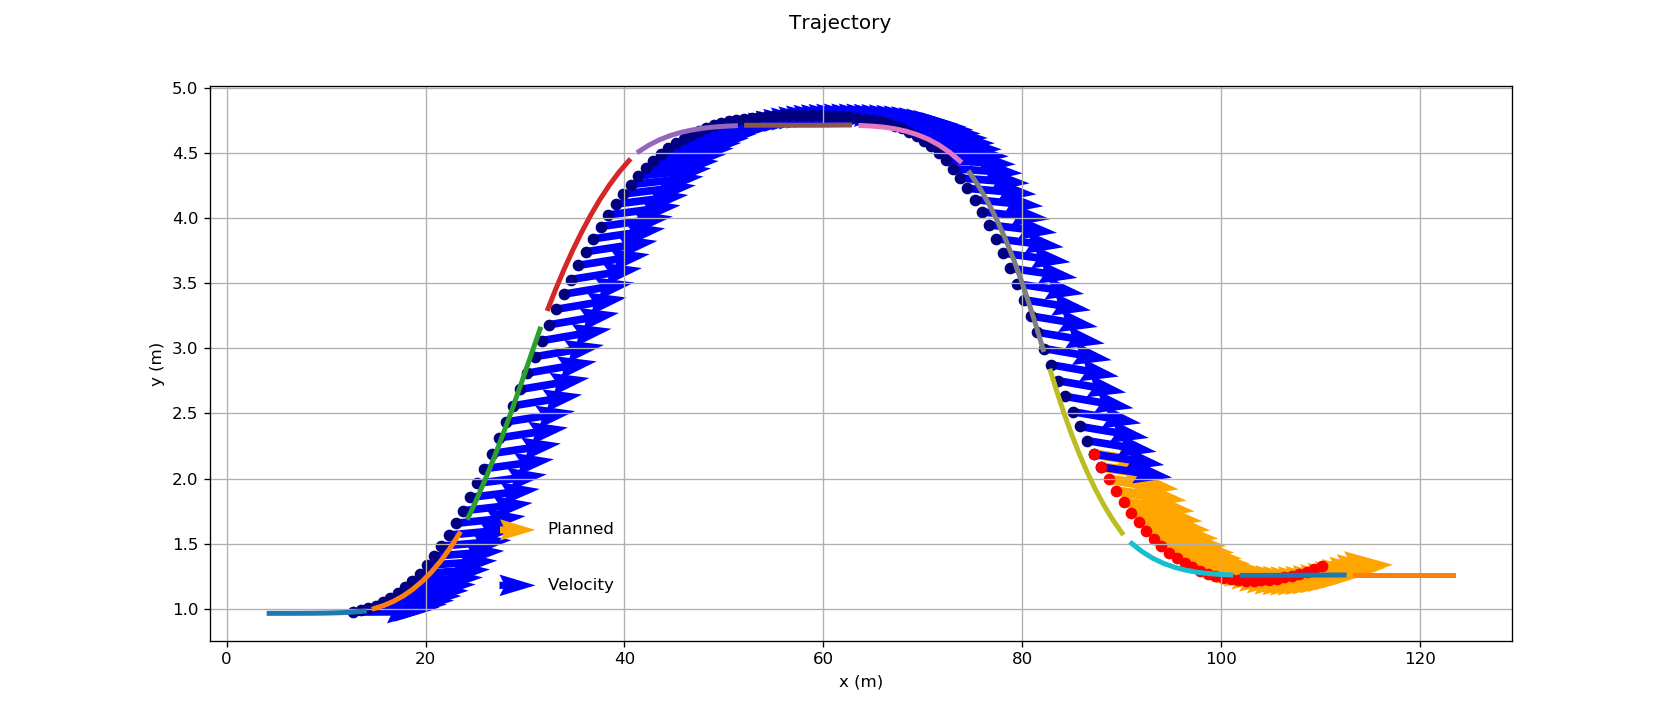

In [10]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
    
roadrunner.plot(ax=x_ax)
plt.show()

## x vs time and y vs time, separately, with the boundaries

<IPython.core.display.Javascript object>


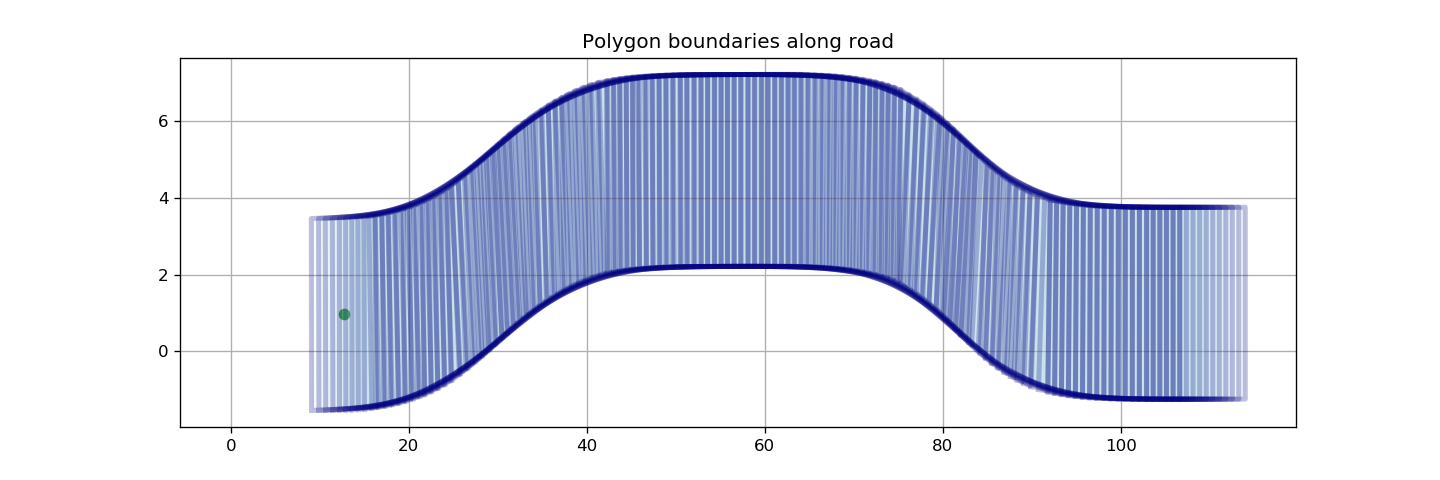

In [11]:
# Plot the road boundary as polygons
def plot_polygons(polygon_boundaries, ax=None):
    n_polys,_,_ = np.shape(polygon_boundaries)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        
    for k in range(n_polys):
        # Plot the polygon fill
        ax.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.1)
        # Plot the line around each polygon
        ax.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.25)

    # Plot the last polygon in RED
    ax.plot(np.concatenate([polygon_boundaries[-1,:,0],polygon_boundaries[-1,0:1,0]]),
            np.concatenate([polygon_boundaries[-1,:,1],polygon_boundaries[-1,0:1,1]]),
            color="red", alpha=0.5)
    return ax

ax = plot_polygons(polygon_boundaries)
ax.scatter(ic[0], ic[1], color="green")
plt.title("Polygon boundaries along road")
plt.show()

<IPython.core.display.Javascript object>


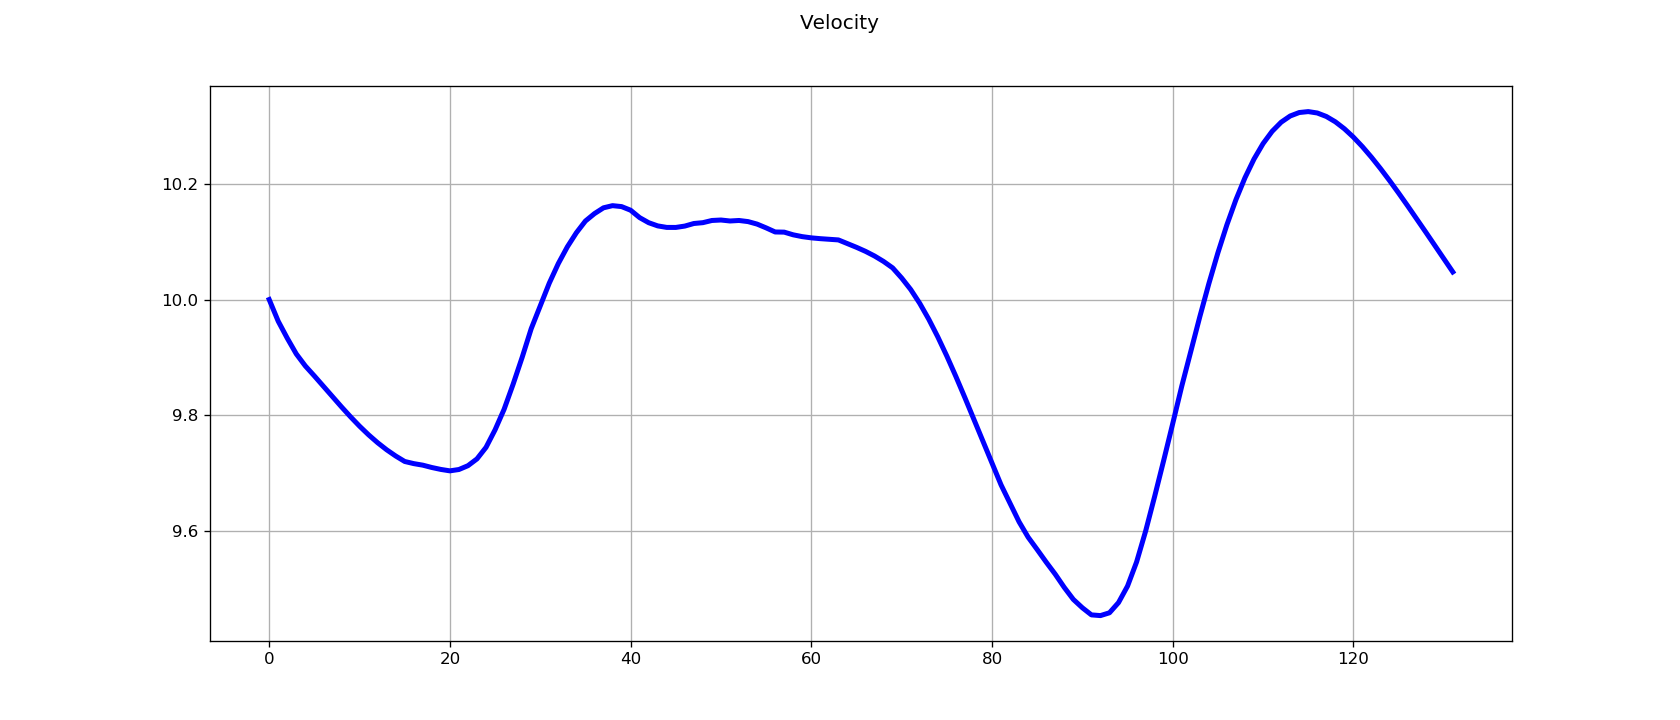

In [12]:
def plot_x(x_executed:np.array, x_planned:np.array):
    fig2, ax = plt.subplots(1,1,
        figsize=(14, 6))

    # Plot the last optimal path computed
    tgrid = np.linspace(0, mpcprob.model.T, mpcprob.model.N)
    vx_plan = np.multiply(x_planned[2],np.cos(x_planned[3]))
    vy_plan = np.multiply(x_planned[2],np.sin(x_planned[3]))

    # Plot the x given
    tgrid = np.linspace(0, mpcprob.model.T, len(x_executed[0]))
    vx_exec = np.multiply(x_executed[2],np.cos(x_executed[3]))
    vy_exec = np.multiply(x_executed[2],np.sin(x_executed[3]))
    vx = np.concatenate([vx_exec, vx_plan[2:]])
    vy = np.concatenate([vy_exec, vy_plan[2:]])
    ax.plot(np.sqrt(vx**2 + vy**2), color="blue")
    
    xs = np.concatenate([x_executed[0], x_planned[0,2:]])
    
    fig2.suptitle("Velocity")

    return fig2, ax
x_plt, x_ax = plot_x(x_plan, mpcprob.x_opt)
plt.show()